<a href="https://colab.research.google.com/github/piltom/materia_machinelearning/blob/main/tp2_solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1
Los datos graficados versus la fecha se muestran a continuación. Se quitaron los datos del dataset de camas que contienen observaciones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd830c6080>,
      dtype=object)

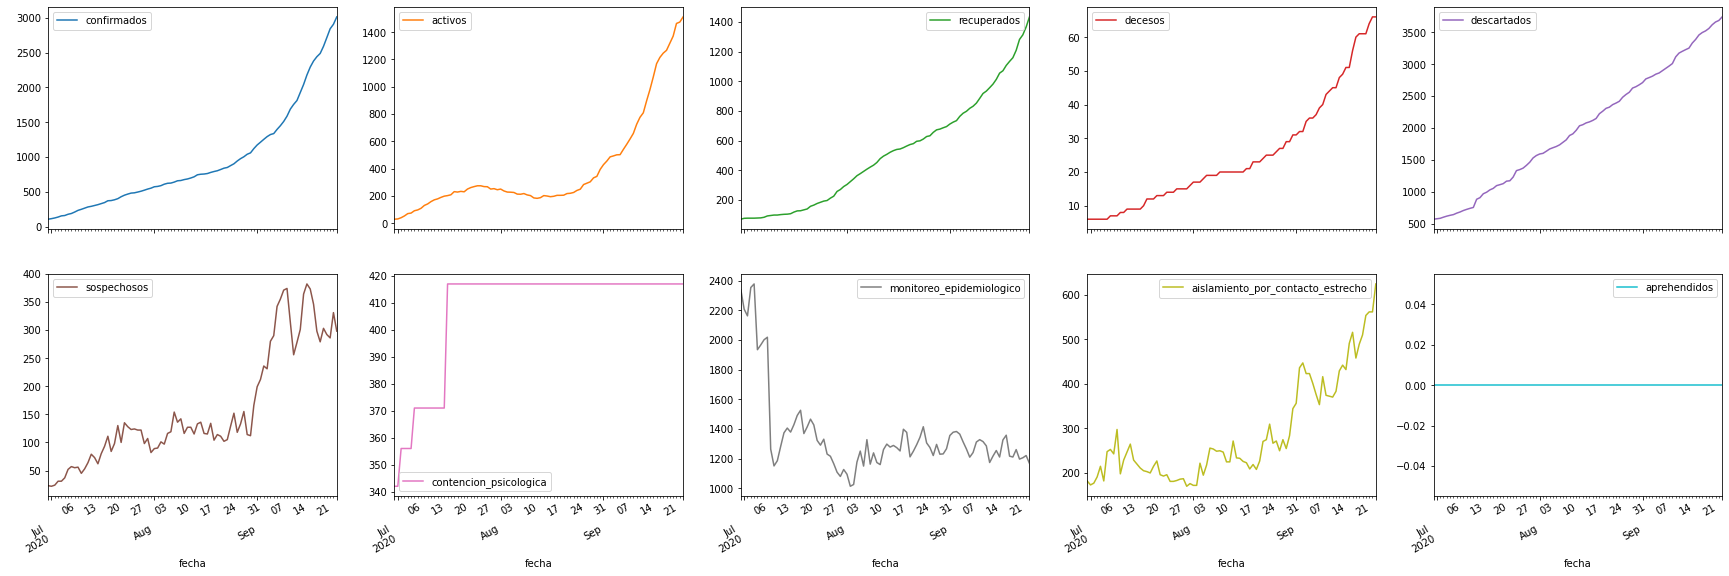

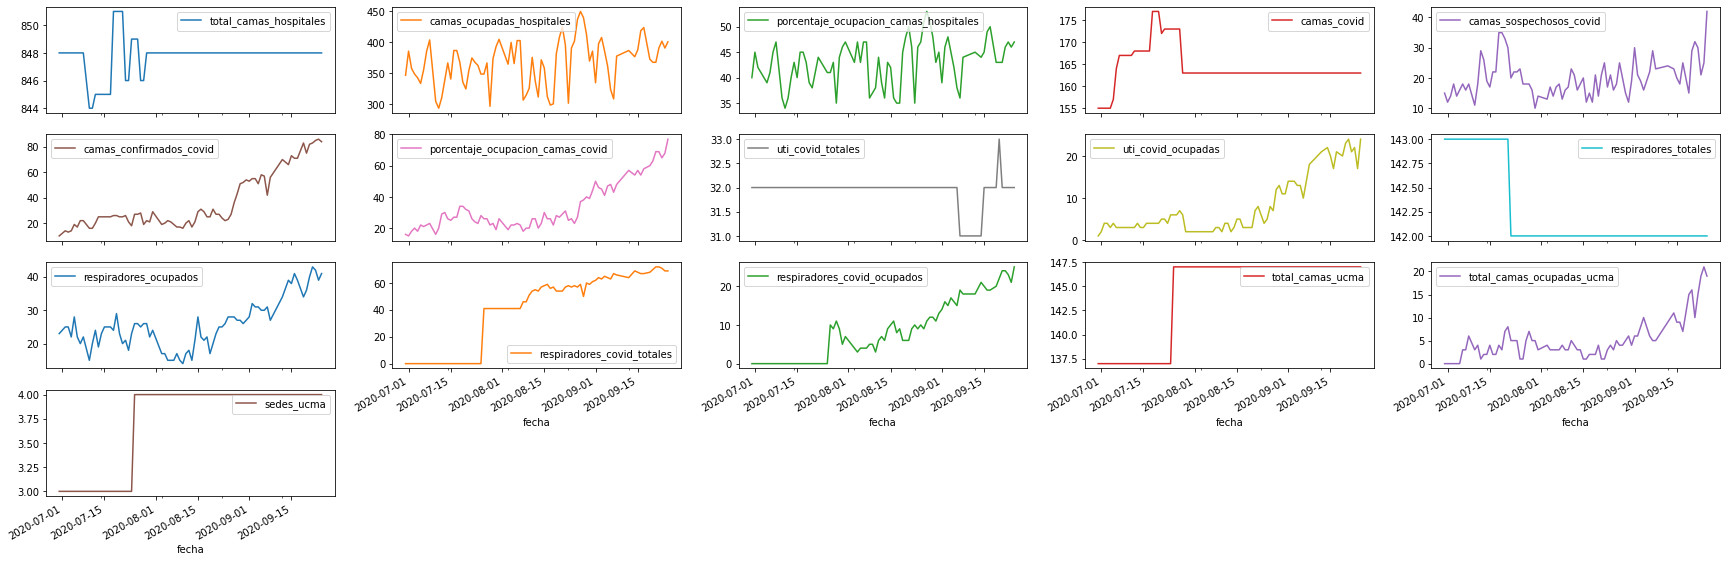

In [31]:
import pandas as pd

casos_bahia_df=pd.read_csv('https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/4_DataWrangling/data/casos_covid_bahia.csv')
camas_bahia_df=pd.read_csv('https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/4_DataWrangling/data/camas_covid_bahia.csv')
casos_bahia_df['fecha'] = casos_bahia_df['fecha'].astype('datetime64[ns]')
camas_bahia_df['fecha'] = camas_bahia_df['fecha'].astype('datetime64[ns]')
casos_bahia_df.set_index('fecha', inplace=True)
camas_bahia_df.set_index('fecha', inplace=True)
camas_bahia_df = camas_bahia_df[camas_bahia_df.observaciones.isnull()]
camas_bahia_df=camas_bahia_df.drop(['observaciones','informeNumero'], axis=1).astype('int64')
casos_bahia_df.plot(subplots= True, layout=(2,5), figsize=(30,10))
camas_bahia_df.plot(subplots= True, layout=(4,5), figsize=(30,10))

Está claro que algunos presentan acumulación a lo largo del tiempo, por lo que probablemente la información interesante se encuentre en la variación entre días (ya sea porcentual o cantidad). Hay dias en los que los valores totales de algunas variables presentan caídas importantes. Verificando la columna observaciones se ve que esto se debe a falta de información de los hospitales (por eso se quitaron del dataset). Aparte de eso, la serie de "Contención psicológica" es bastante extraña, con 3 saltos entre valores fijos, sin pequeños incrementos día a día. Las series correspondientes a sedes ucma (Unidades de Cuidados Mínimos Ambulatorios) y total de camas ucma reflejan únicamente la apertura de una unidad nueva.

# Casos bahia - incremento porcentual
En el siguiente plot se muestran histogramas del aumento intradiario porcentual de los datos del dataset de casos. Un histograma de los datos "crudos" no tendría mucho valor ya que se tratan de valores acumulativos en general. Hay ciertos números que solo pueden incrementar (confirmados, decesos, descartados), por lo que su incremento jamás tendría una distribución normal. Sin embargo parecen estimables por una distribución log-normal.
Quizás la variación intradiaria de activos podría estimarse con una normal. Al tratarse de aumento porcentual, tener una media por encima de 0 significa crecimiento casi exponencial de casos activos (por el "interés compuesto").

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd861cd9e8>,
      dtype=object)

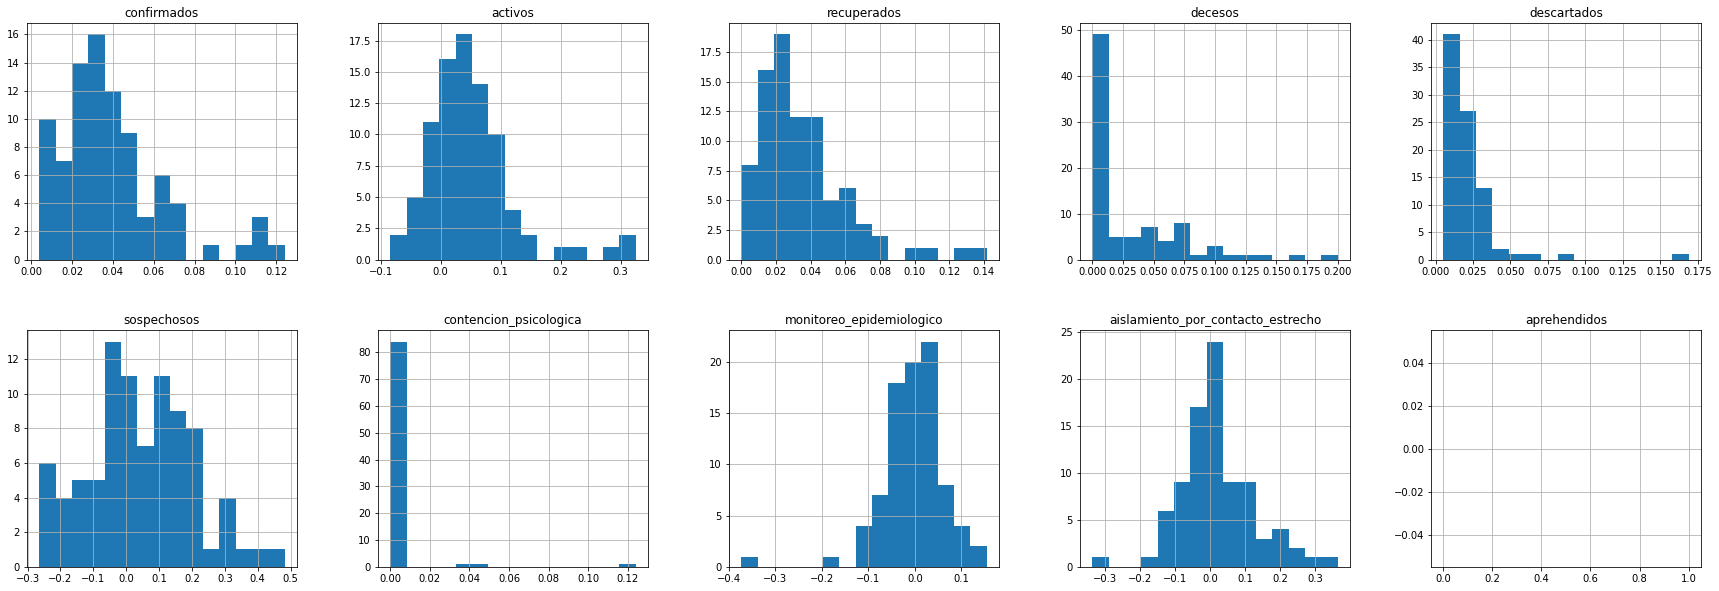

In [32]:
casos_bahia_df.pct_change().hist( layout=(2,5), figsize=(30,10), bins=15)


# Camas bahía - totales e incremento
En el caso del dataset de camas, algunas variables tiene mas sentido analizarlas por el incremento y otras por su total. Varias de estas variables son totales de recursos disponibles que no cambian mucho, que son mayormente útiles para realizar cálculos y producir otras métricas.
Los histogramas de valores totales son:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd83d45e48>,
      dtype=object)

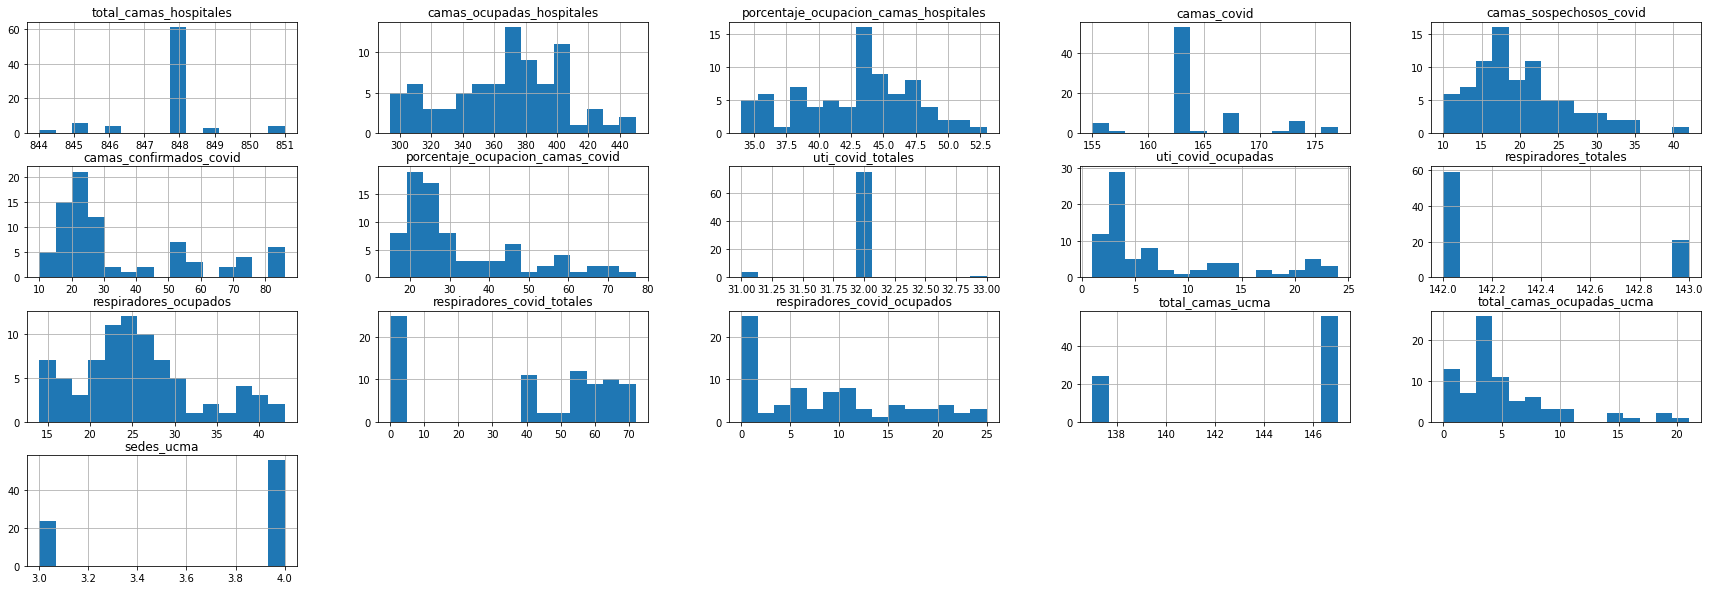

In [33]:
camas_bahia_df.hist( layout=(4,5), figsize=(30,10), bins=15)

Ninguno parece tener distribución normal.
En el caso del incremento de las cantidades, los histogramas resultan:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd84378438>,
      dtype=object)

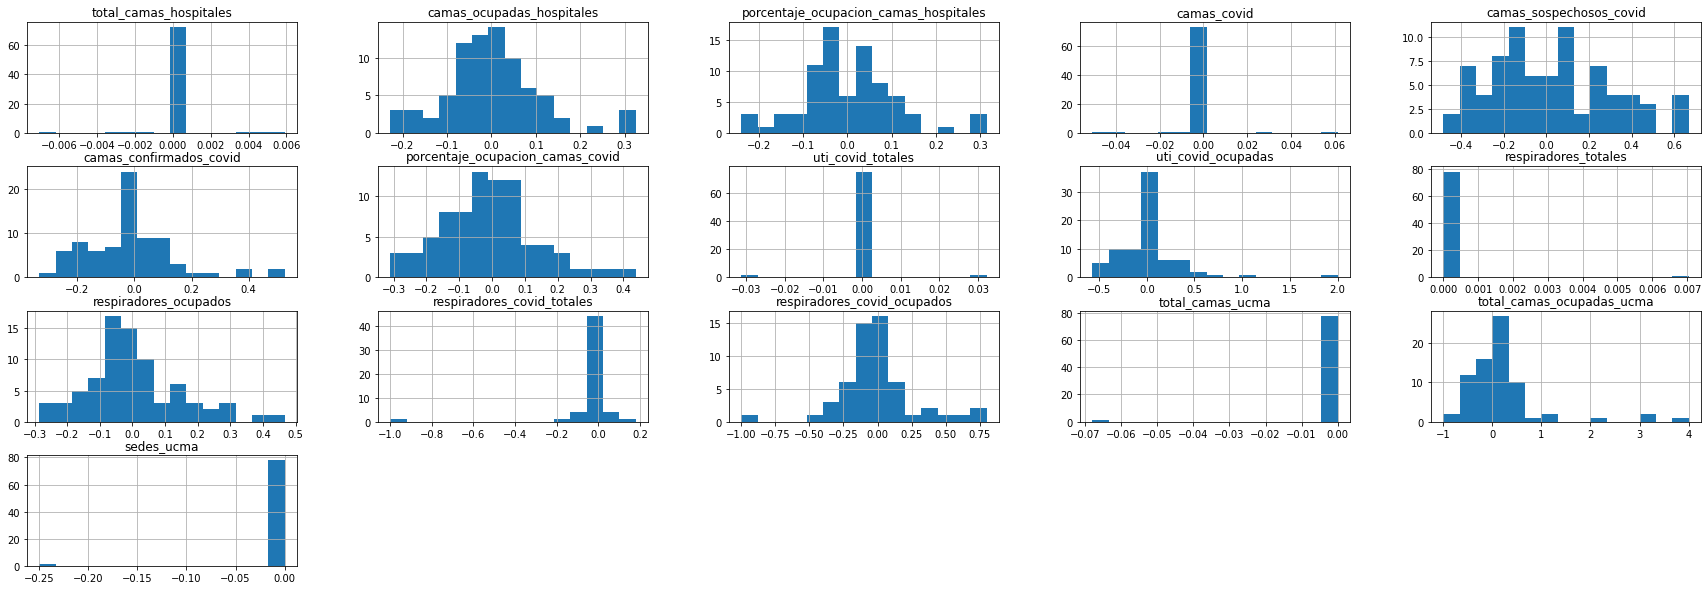

In [34]:

camas_bahia_df.pct_change().hist( layout=(4,5), figsize=(30,10), bins=15)

En estos gráficos se ve que el total de recursos cambia poco (la mayoría de las variaciones son 0). El incremento del porcentaje de ocupación de camas podría razonablemente considerarse normal con media cercana a 0.

# Ejercicio 2

In [72]:
import numpy as np

setA=pd.DataFrame(np.random.normal(0,3,50),columns=['val'])
setA['etiqueta']='A'
setB=pd.DataFrame(np.random.normal(4,2,50),columns=['val'])
setB['etiqueta']='B'
combinedSet=pd.concat([setA,setB], ignore_index=True).sort_values(by='val',ignore_index=True)
combinedSet

,val,etiqueta
0,-9.226712,A
1,-7.393667,A
2,-4.832250,A
3,-4.782874,A
4,-4.779503,A
...,...,...
95,6.782929,B
96,6.953852,B
97,7.680077,B
98,7.886636,B


La curva ROC resulta:

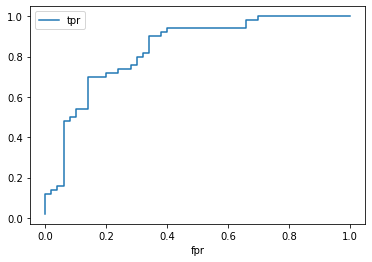

In [110]:
def clasif_confusion(etiqueta, prediccion, positivo):
  if etiqueta==prediccion:
    if prediccion==positivo:
      return 'TP'
    else:
      return 'TN'
  else:
    if prediccion==positivo:
      return 'FP'
    else:
      return 'FN'
def genConfusionData(arg_set, thresh):
    arg_set['prediccion'] = arg_set.apply(lambda row: 'A' if row.val < thresh else 'B', axis=1)
    arg_set['confusion']  = arg_set.apply(lambda row: clasif_confusion(row.etiqueta, row.prediccion, 'B'), axis=1)
    return arg_set
def getRocData(arg_set):
  tpr_list=[]
  fpr_list=[]
  thresh_list=[]
  for thresh in arg_set['val'].values:
    arg_set=genConfusionData(arg_set, thresh)
    tps=len(arg_set[arg_set['confusion']=='TP'])
    tns=len(arg_set[arg_set['confusion']=='TN'])
    fps=len(arg_set[arg_set['confusion']=='FP'])
    fns=len(arg_set[arg_set['confusion']=='FN'])
    if (tps+fns)!=0 and (fps+tns)!=0:
      tpr_list.append(tps/(tps+fns))
      fpr_list.append(fps/(fps+tns))
      thresh_list.append(thresh)
  return pd.DataFrame({'fpr':fpr_list, 'tpr':tpr_list, 'thresh':thresh_list})

roc_frame=getRocData(combinedSet)
roc_frame.plot.line(x='fpr', y='tpr')

Para conseguir el minimo error debería elegir un umbral que corresponda al punto de la curva ROC más cercano al punto (0,1) (esquina superior izquierda). Este umbral en codigo se encuentra como:

In [111]:
roc_frame['distideal']=roc_frame.apply(lambda row: (row.tpr-1)**2 + row.fpr**2, axis=1)
best_thresh=roc_frame.at[roc_frame['distideal'].idxmin(), 'thresh']
print(best_thresh)

2.5467803411896606


Para este threshold, la exactitud, precisión y f-measure son:

In [112]:
confdata=genConfusionData(combinedSet,best_thresh)
tps=len(confdata[confdata['confusion']=='TP'])
tns=len(confdata[confdata['confusion']=='TN'])
fps=len(confdata[confdata['confusion']=='FP'])
fns=len(confdata[confdata['confusion']=='FN'])
accu=(tps+tns)/len(confdata)
prec=tps/(tps+fps)
recall=tps/(tps+fns)
fmeas=2*prec*recall/(prec+recall)
print('Exactitud: %.2f Precision: %.2f F-measure: %.2f' % (accu,prec,fmeas))

Exactitud: 0.78 Precision: 0.83 F-measure: 0.76


Cambiando el threshold (a 4) se puede ver como si bien puede ser que la precision mejora, empeoran las otras métricas:

In [113]:
confdata=genConfusionData(combinedSet,4)
tps=len(confdata[confdata['confusion']=='TP'])
tns=len(confdata[confdata['confusion']=='TN'])
fps=len(confdata[confdata['confusion']=='FP'])
fns=len(confdata[confdata['confusion']=='FN'])
accu=(tps+tns)/len(confdata)
prec=tps/(tps+fps)
recall=tps/(tps+fns)
fmeas=2*prec*recall/(prec+recall)
print('Exactitud: %.2f Precision: %.2f F-measure: %.2f' % (accu,prec,fmeas))

Exactitud: 0.69 Precision: 0.88 F-measure: 0.59


Ahora cambiando los datos, haciendo las medias mas separadas y usando un threshold ideal, podemos ver como las métricas mejoran, ya que es más fácil de distinguir entre uno y otro. Ya se puede ver que el area bajo la curva ROC es mayor para este dataset, lo que significa una mejor clasificación.

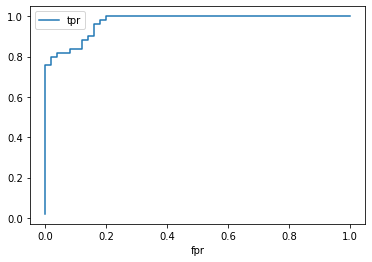

In [119]:
setA2=pd.DataFrame(np.random.normal(0,3,50),columns=['val'])
setA2['etiqueta']='A'
setB2=pd.DataFrame(np.random.normal(7,2,50),columns=['val'])
setB2['etiqueta']='B'
combinedSet2=pd.concat([setA2,setB2], ignore_index=True).sort_values(by='val',ignore_index=True)
roc_frame2=getRocData(combinedSet2)
roc_frame2.plot.line(x='fpr', y='tpr')

In [122]:
roc_frame2['distideal']=roc_frame2.apply(lambda row: (row.tpr-1)**2 + row.fpr**2, axis=1)
best_thresh2=roc_frame2.at[roc_frame2['distideal'].idxmin(), 'thresh']
confdata2=genConfusionData(combinedSet2,best_thresh2)
tps2=len(confdata2[confdata2['confusion']=='TP'])
tns2=len(confdata2[confdata2['confusion']=='TN'])
fps2=len(confdata2[confdata2['confusion']=='FP'])
fns2=len(confdata2[confdata2['confusion']=='FN'])
accu2=(tps2+tns2)/len(confdata2)
prec2=tps2/(tps2+fps2)
recall2=tps2/(tps2+fns2)
fmeas2=2*prec2*recall2/(prec2+recall2)
print('Exactitud: %.2f Precision: %.2f F-measure: %.2f' % (accu2,prec2,fmeas2))

Exactitud: 0.90 Precision: 0.86 F-measure: 0.91


Para hacer este proceso no supervisado, se debe implementar algún criterio de selección de punto de la curva ROC. En este trabajo se eligió el más cercano al punto ideal (1,0), pero se puede también incluir costos para la distancia al ideal en cada eje.

# Ejercicio 3
Para el caso de datos 2D, el umbral sería una curva, y distintos valores de umbral corresponderían a mover esta curva. Sin ninguna estimación se necesitarían dos umbrales, uno para cada variable y la curva ROC no se podría construir. Debería obtener la superficie discriminante para clasificar y parametrizarla con el término constante para construir la curva ROC